### Chargement et prise en main des données

In [1]:
import json
import numpy as np
import networkx as nx
from collections import defaultdict, Counter
from typing import Dict, List, Tuple
import os
import pickle
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import warnings
warnings.filterwarnings('ignore')

# For embeddings and similarity computation
try:
    from sentence_transformers import SentenceTransformer
    print("Required libraries imported successfully!")
except ImportError as e:
    print(f"Missing library: {e}")
    print("Please install with: pip install sentence-transformers scikit-learn networkx")

np.random.seed(42)

Required libraries imported successfully!


In [2]:
from scipy.sparse import find, csr_matrix
import matplotlib.pyplot as plt
import pandas as pd
from scipy.linalg import norm
from IPython.core.display import HTML

# des options permettent de limiter (ou non) le nombre de lignes/colonnes affichées
# par exemple :
# pd.set_option('display.max_rows', None)

# cette fonction permet d'afficher une "jolie" représentation du vecteur v
# ARGS :
#   v : le vecteur à afficher (par ex. une ligne de la matrice X)
#   features : le vocabulaire
#   top_n : le nombre de mots maximum à afficher
def print_feats(v, features, top_n = 30):
    _, ids, values = find(v)
    feats = [(ids[i], values[i], features[ids[i]]) for i in range(len(list(ids)))]
    top_feats = sorted(feats, key=lambda x: x[1], reverse=True)[0:top_n]
    return pd.DataFrame({"word" : [t[2] for t in top_feats], "value": [t[1] for t in top_feats]})   

# fonction qui permet d'afficher plusieurs tables pandas côte à côte (c'est cadeau)
def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "&emsp;"
        #output += "\xa0\xa0\xa0"
    display(HTML(output))

In [3]:
def load_corpus(file_path: str) -> Dict[str, Dict]:
    """
    Load corpus data from JSONL file.
    Returns dictionary mapping document IDs to document data.
    """
    out_dict = {}
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            data = json.loads(line)
            id = data['_id']
            del data['_id']
            out_dict[id] = data 
    return out_dict
   
def load_queries(file_path: str) -> Dict[str, Dict]:
    """
    Load query data from JSONL file.
    Returns dictionary mapping query IDs to query data.
    """
    out_dict = {}
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            data = json.loads(line)
            id = data['_id']
            del data['_id']
            out_dict[id] = data 
    return out_dict

def load_qrels(file_path: str) -> Dict[str, Dict[str, int]]:
    """    
    Load relevance judgments from TSV file.
    Returns dictionary mapping query IDs to candidate relevance scores.
    """
    data = pd.read_csv(file_path, sep = '\t')
    out = {
    query_id: {r['corpus-id']: r['score'] for _, r in grp.iterrows()}
    for query_id, grp in data.groupby('query-id')
    }
    return out
    

In [4]:
file_path_corpus = "dataset_BE2/corpus.jsonl"
corpus = load_corpus(file_path_corpus)

file_path_query = "dataset_BE2/queries.jsonl"
queries = load_queries(file_path_query)

file_path_qrels = "dataset_BE2/valid.tsv"
qrels = load_qrels(file_path_qrels)

### Exploration des données et premier encodage

In [5]:
# Corpus
sample_corpus_id = list(corpus.keys())[0]
print("Sample corpus ID:", sample_corpus_id)
print("Corpus fields:", corpus[sample_corpus_id].keys())

# Queries
sample_query_id = list(queries.keys())[0]
print("\nSample query ID:", sample_query_id)
print("Query fields:", queries[sample_query_id].keys())

Sample corpus ID: 632589828c8b9fca2c3a59e97451fde8fa7d188d
Corpus fields: dict_keys(['title', 'text', 'metadata'])

Sample query ID: 78495383450e02c5fe817e408726134b3084905d
Query fields: dict_keys(['text', 'metadata'])


In [6]:
titles = []
for key, dic in corpus.items():
    title = dic['title']
    titles.append(title)

In [7]:
count_vectorizer = CountVectorizer()
count_vectorizer.fit(titles)

,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None
,stop_words,None
,token_pattern,'(?u)\\b\\w\\w+\\b'
,ngram_range,"(1, ...)"
,analyzer,'word'


In [8]:
titles_matrix = count_vectorizer.transform(titles)

In [9]:
titles_matrix.shape

(25657, 20075)

In [10]:
count_vectorizer.vocabulary_

{'hybrid': 8630,
 'of': 12584,
 'genetic': 7657,
 'algorithm': 948,
 'and': 1149,
 'particle': 13193,
 'swarm': 17668,
 'optimization': 12764,
 'for': 7259,
 'recurrent': 15022,
 'network': 12138,
 'design': 5077,
 'ep': 6303,
 'sqp': 17031,
 'dynamic': 5750,
 'economic': 5852,
 'dispatch': 5401,
 'with': 19810,
 'nonsmooth': 12374,
 'fuel': 7464,
 'cost': 4266,
 'function': 7473,
 'fuzzy': 7506,
 'systems': 17771,
 'evolutionary': 6513,
 'tuning': 18718,
 'learning': 10101,
 'knowledge': 9865,
 'bases': 1981,
 'modified': 11480,
 'optimizer': 12768,
 'identification': 8770,
 'control': 4113,
 'using': 19116,
 'neural': 12144,
 'networks': 12141,
 'separate': 16211,
 'face': 6749,
 'body': 2429,
 'selectivity': 16131,
 'on': 12648,
 'the': 18107,
 'fusiform': 7496,
 'gyrus': 8062,
 'scheduling': 15917,
 'reduced': 15041,
 'cpu': 4327,
 'energy': 6211,
 'data': 4675,
 'mining': 11343,
 'approach': 1352,
 'location': 10384,
 'prediction': 14075,
 'in': 8947,
 'mobile': 11441,
 'environme

In [11]:
features = count_vectorizer.get_feature_names_out()

for i in range(2):
    print(f"\n==== Document {i} ====")
    display(print_feats(titles_matrix[i], features))


==== Document 0 ====


,word,value
0,algorithm,1
1,and,1
2,design,1
3,for,1
4,genetic,1
5,hybrid,1
6,network,1
7,of,1
8,optimization,1
9,particle,1



==== Document 1 ====


,word,value
0,and,1
1,cost,1
2,dispatch,1
3,dynamic,1
4,economic,1
5,ep,1
6,for,1
7,fuel,1
8,function,1
9,hybrid,1


<Axes: xlabel='word'>

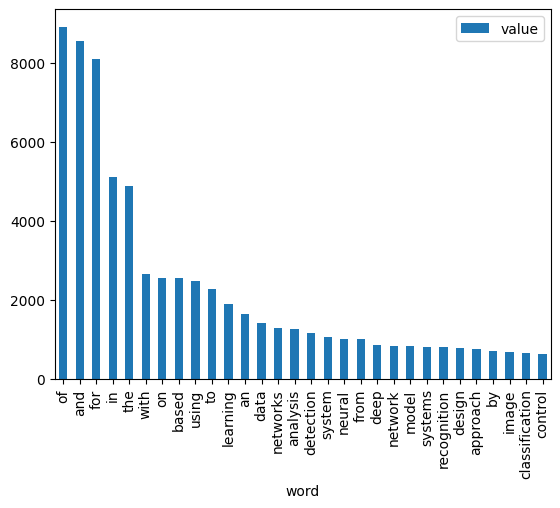

In [12]:
print_feats(titles_matrix.sum(axis=0),count_vectorizer.get_feature_names_out()).plot.bar(x='word',y='value')

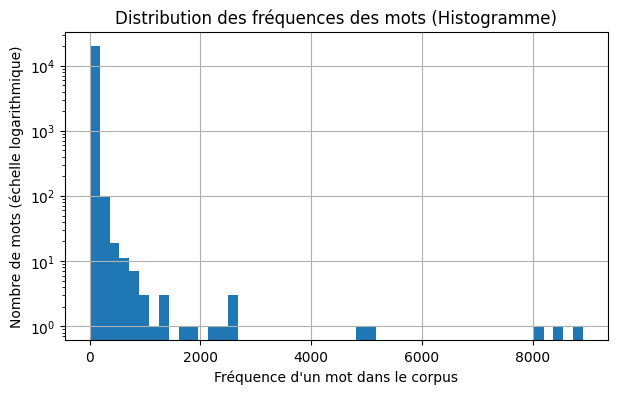

In [13]:
# Somme des occurrences par mot (colonne)
word_frequencies = np.array(titles_matrix.sum(axis=0)).flatten()

# On enlève les mots qui apparaissent 0 fois (par sécurité)
word_frequencies = word_frequencies[word_frequencies > 0]

plt.figure(figsize=(7, 4))
plt.hist(word_frequencies, bins=50, log=True)
plt.xlabel("Fréquence d'un mot dans le corpus")
plt.ylabel("Nombre de mots (échelle logarithmique)")
plt.title("Distribution des fréquences des mots (Histogramme)")
plt.grid(True)
plt.show()


### Comparaison de documents et premier moteur de

In [14]:
cos_similarities = cosine_similarity(titles_matrix)

In [15]:
queries_texts = []
for id, dic in queries.items():
    text = dic['text']
    queries_texts.append(text)

In [16]:
queries_matrix = count_vectorizer.transform(queries_texts)

In [17]:
queries_matrix.shape

(1000, 20075)

In [18]:
distances = []
query = queries_matrix[0].toarray()
for i in range(titles_matrix.shape[0]):
    x = titles_matrix[i].toarray()
    dist = cosine_similarity(query,x)
    distances.append(dist)

In [19]:
distances = np.array(distances).flatten()

In [20]:
returns = count_vectorizer.inverse_transform(titles_matrix[np.flip(np.argsort(distances))[:10]])

In [21]:
for title in returns:
    print(' '.join(title))

direct golden hyper method over rectangle search section
generator get networks point pointer summarization the to with
algorithm approach cuckoo metaheuristic optimization problems search solve structural to
capability dynamic evolutionary learning problem routing search solving vehicle via with
accuracy history improve long mining search term to
inexact perceptron search structured with
direct of point sets visibility
guide search tabu to user
attention details styling to with
2v 341gb 64gb and bank control data dram group hbm2 improved point spiral stacked structure to tsv with


We test cosine similarity on a few document pairs to compare semantically close and distant texts

In [22]:
doc_a = 0
doc_b = 1      # likely related
doc_c = 5000   # likely unrelated

sim_close = cosine_similarity(titles_matrix[doc_a], titles_matrix[doc_b])[0, 0]
sim_far = cosine_similarity(titles_matrix[doc_a], titles_matrix[doc_c])[0, 0]

print("Document A title:", corpus[list(corpus.keys())[doc_a]]['title'])
print("Document B title:", corpus[list(corpus.keys())[doc_b]]['title'])
print("Cosine similarity (close pair):", sim_close)

print("\nDocument A title:", corpus[list(corpus.keys())[doc_a]]['title'])
print("Document C title:", corpus[list(corpus.keys())[doc_c]]['title'])
print("Cosine similarity (far pair):", sim_far)


Document A title: A hybrid of genetic algorithm and particle swarm optimization for recurrent network design
Document B title: A Hybrid EP and SQP for Dynamic Economic Dispatch with Nonsmooth Fuel Cost Function
Cosine similarity (close pair): 0.24019223070763074

Document A title: A hybrid of genetic algorithm and particle swarm optimization for recurrent network design
Document C title: Noninvasive diagnosis of fetal aneuploidy by shotgun sequencing DNA from maternal blood.
Cosine similarity (far pair): 0.08333333333333336


We now display the top-10 retrieved documents with their titles and cosine similarity scores.

In [23]:
top_indices = np.flip(np.argsort(distances))[:10]
corpus_ids = list(corpus.keys())

for rank, idx in enumerate(top_indices, start=1):
    doc_id = corpus_ids[idx]
    title = corpus[doc_id]['title']
    score = distances[idx]
    print(f"{rank}. Score={score:.4f} | {title}")

1. Score=0.3482 | Golden section search over hyper-rectangle: a direct search method
2. Score=0.2887 | Get To The Point: Summarization with Pointer-Generator Networks
3. Score=0.2739 | Cuckoo search algorithm: a metaheuristic approach to solve structural optimization problems
4. Score=0.2611 | Solving dynamic vehicle routing problem via evolutionary search with learning capability
5. Score=0.2611 | Mining long-term search history to improve search accuracy
6. Score=0.2582 | Structured Perceptron with Inexact Search
7. Score=0.2582 | Direct visibility of point sets
8. Score=0.2582 | A user's guide to tabu search
9. Score=0.2582 | Styling with Attention to Details
10. Score=0.2520 | A 1.2V 64Gb 341GB/S HBM2 stacked DRAM with spiral point-to-point TSV structure and improved bank group data control


TFxIDF

In [24]:
tfid_vectorizer = TfidfVectorizer()
tfid_vectorizer.fit(titles)

,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None
,analyzer,'word'
,stop_words,None
,token_pattern,'(?u)\\b\\w\\w+\\b'
,ngram_range,"(1, ...)"


In [25]:
titles_matrix = tfid_vectorizer.transform(titles)
queries_matrix = tfid_vectorizer.transform(queries_texts)

In [26]:
distances = []
query = queries_matrix[0].toarray()
for i in range(titles_matrix.shape[0]):
    x = titles_matrix[i].toarray()
    dist = cosine_similarity(query,x)
    distances.append(dist)

In [27]:
distances = np.array(distances).flatten()
returns = count_vectorizer.inverse_transform(titles_matrix[np.flip(np.argsort(distances))[:10]])
for title in returns:
    print(' '.join(title))

dispatch distributed economic event for grids in scheme smart triggered
considering cost dispatch economic energy for functions microgrid renewable
and cost dispatch dynamic economic ep for fuel function hybrid nonsmooth sqp with
direct of point sets visibility
direct golden hyper method over rectangle search section
algorithm approach cuckoo metaheuristic optimization problems search solve structural to
analyzing mutation of operators performance problem salesman solve the to travelling
as coded correspondence in light problem progress recent solve structured survey technique the to
and development diversity economic network
intermediate math problems representations solve to using word


In [28]:
top_indices = np.flip(np.argsort(distances))[:10]
corpus_ids = list(corpus.keys())

for rank, idx in enumerate(top_indices, start=1):
    doc_id = corpus_ids[idx]
    title = corpus[doc_id]['title']
    score = distances[idx]
    print(f"{rank}. Score={score:.4f} | {title}")


1. Score=0.2827 | Distributed Event-Triggered Scheme for Economic Dispatch in Smart Grids
2. Score=0.2739 | Economic dispatch for a microgrid considering renewable energy cost functions
3. Score=0.2452 | A Hybrid EP and SQP for Dynamic Economic Dispatch with Nonsmooth Fuel Cost Function
4. Score=0.2441 | Direct visibility of point sets
5. Score=0.2395 | Golden section search over hyper-rectangle: a direct search method
6. Score=0.2344 | Cuckoo search algorithm: a metaheuristic approach to solve structural optimization problems
7. Score=0.2272 | Analyzing the Performance of Mutation Operators to Solve the Travelling Salesman Problem
8. Score=0.2203 | Recent progress in coded structured light as a technique to solve the correspondence problem: a survey
9. Score=0.1918 | Network diversity and economic development.
10. Score=0.1892 | Using Intermediate Representations to Solve Math Word Problems


### Utiliser un meilleur encodeur de documents

Sentence-transformers

In [29]:
def build_doc_text(doc):
    title = doc.get("title", "")
    abstract = doc.get("abstract", "")
    return (title or "") + " " + (abstract or "")

corpus_ids = list(corpus.keys())
corpus_texts = [build_doc_text(corpus[doc_id]) for doc_id in corpus_ids]

query_ids = list(queries.keys())
query_texts = [queries[q_id].get("text", "") for q_id in query_ids]

In [30]:
emb_dir = "embeddings"
os.makedirs(emb_dir, exist_ok=True)

# List of models to compare
models_to_compare = [
    "all-MiniLM-L6-v2",
    "paraphrase-MiniLM-L6-v2",
    "all-mpnet-base-v2"
]

embeddings_data = {}

for model_name in models_to_compare:
    corpus_emb_path = os.path.join(emb_dir, f"corpus_embeddings_{model_name}.npy")
    query_emb_path = os.path.join(emb_dir, f"query_embeddings_{model_name}.npy")
    corpus_ids_path = os.path.join(emb_dir, f"corpus_ids_{model_name}.pkl")
    query_ids_path = os.path.join(emb_dir, f"query_ids_{model_name}.pkl")

    if os.path.exists(corpus_emb_path) and os.path.exists(query_emb_path):
        print(f"Loading existing embeddings for {model_name}...")
        corpus_embeddings = np.load(corpus_emb_path)
        query_embeddings = np.load(query_emb_path)
        
        with open(corpus_ids_path, "rb") as f:
            corpus_ids_loaded = pickle.load(f)
        with open(query_ids_path, "rb") as f:
            query_ids_loaded = pickle.load(f)
    else:
        print(f"Computing embeddings with {model_name}...")
        model = SentenceTransformer(model_name)
        
        corpus_embeddings = model.encode(
            corpus_texts,
            batch_size=64,
            show_progress_bar=True,
            convert_to_numpy=True,
            normalize_embeddings=True
        )
        
        query_embeddings = model.encode(
            query_texts,
            batch_size=64,
            show_progress_bar=True,
            convert_to_numpy=True,
            normalize_embeddings=True
        )
        
        np.save(corpus_emb_path, corpus_embeddings)
        np.save(query_emb_path, query_embeddings)
        with open(corpus_ids_path, "wb") as f:
            pickle.dump(corpus_ids, f)
        with open(query_ids_path, "wb") as f:
            pickle.dump(query_ids, f)

    embeddings_data[model_name] = {
        'corpus_embeddings': corpus_embeddings,
        'query_embeddings': query_embeddings,
        'corpus_ids': corpus_ids,
        'query_ids': query_ids
    }

    print(f"{model_name} - Corpus embeddings shape: {corpus_embeddings.shape}")
    print(f"{model_name} - Query embeddings shape: {query_embeddings.shape}")
    print()

Loading existing embeddings for all-MiniLM-L6-v2...
all-MiniLM-L6-v2 - Corpus embeddings shape: (25657, 384)
all-MiniLM-L6-v2 - Query embeddings shape: (1000, 384)

Loading existing embeddings for paraphrase-MiniLM-L6-v2...
paraphrase-MiniLM-L6-v2 - Corpus embeddings shape: (25657, 384)
paraphrase-MiniLM-L6-v2 - Query embeddings shape: (1000, 384)

Loading existing embeddings for all-mpnet-base-v2...
all-mpnet-base-v2 - Corpus embeddings shape: (25657, 768)
all-mpnet-base-v2 - Query embeddings shape: (1000, 768)



Retrieve top-k documents for a given query using dense embeddings

In [31]:
def search_with_embeddings(query_id, corpus_embeddings, query_embeddings, corpus_ids, query_ids, top_k=10):
    
    query_index = {qid: idx for idx, qid in enumerate(query_ids)}
    
    if query_id not in query_index:
        raise ValueError("Query ID not found in query embeddings.")
    
    qidx = query_index[query_id]
    q_emb = query_embeddings[qidx].reshape(1, -1)
    
    sims = cosine_similarity(q_emb, corpus_embeddings)[0]
    top_idx = np.argsort(-sims)[:top_k]
    
    results = []
    for i in top_idx:
        doc_id = corpus_ids[i]
        score = sims[i]
        title = corpus[doc_id].get("title", "")
        results.append((doc_id, score, title))
    
    return results


example_qid = query_ids[0]
results = search_with_embeddings(
    example_qid,
    corpus_embeddings,
    query_embeddings,
    corpus_ids,
    query_ids,
    top_k=10
)

for rank, (doc_id, score, title) in enumerate(results, start=1):
    print(f"{rank}. Score={score:.4f} | {title}")


1. Score=0.6717 | A Hybrid EP and SQP for Dynamic Economic Dispatch with Nonsmooth Fuel Cost Function
2. Score=0.5190 | Optimization by Direct Search: New Perspectives on Some Classical and Modern Methods
3. Score=0.5043 | Economic dispatch for a microgrid considering renewable energy cost functions
4. Score=0.4864 | A Taxi Order Dispatch Model based On Combinatorial Optimization
5. Score=0.4801 | Artificial cooperative search algorithm for numerical optimization problems
6. Score=0.4618 | Constrained Two-dimensional Cutting Stock Problems a Best-first Branch-and-bound Algorithm Constrained Two-dimensional Cutting Stock Problems a Best-first Branch-and-bound Algorithm
7. Score=0.4437 | The Whale Optimization Algorithm
8. Score=0.4433 | Direct Multisearch for Multiobjective Optimization
9. Score=0.4279 | Backtracking search algorithm in CVRP models for efficient solid waste collection and route optimization.
10. Score=0.4199 | Dispatching optimization and routing guidance for emergency 

In [32]:
from sklearn.metrics import roc_auc_score

def evaluate_dense_search(qrels, corpus_embeddings, query_embeddings, corpus_ids, query_ids, top_k=5):
    corpus_index = {doc_id: idx for idx, doc_id in enumerate(corpus_ids)}
    query_index = {q_id: idx for idx, q_id in enumerate(query_ids)}
    
    precisions = []
    recalls = []
    f1s = []
    aucs = []

    for qid, cand_dict in qrels.items():
        if qid not in query_index:
            continue
        
        qidx = query_index[qid]
        q_emb = query_embeddings[qidx].reshape(1, -1)

        candidate_ids = list(cand_dict.keys())
        
        candidate_ids = [cid for cid in candidate_ids if cid in corpus_index]
        if len(candidate_ids) == 0:
            continue
        
        cand_indices = [corpus_index[cid] for cid in candidate_ids]
        cand_embs = corpus_embeddings[cand_indices]

        sims = cosine_similarity(q_emb, cand_embs)[0]
        y_true = np.array([cand_dict[cid] for cid in candidate_ids])  # 0 or 1
        
        order = np.argsort(-sims)
        sims_sorted = sims[order]
        y_sorted = y_true[order]
        
        k = min(top_k, len(y_sorted))
        y_pred_bin = np.zeros_like(y_sorted)
        y_pred_bin[:k] = 1
        
        tp = (y_pred_bin[:k] * y_sorted[:k]).sum()
        nb_pos = y_sorted.sum()
        
        if k > 0:
            prec = tp / k
        else:
            prec = 0.0
        
        if nb_pos > 0:
            rec = tp / nb_pos
        else:
            rec = 0.0
        
        if prec + rec > 0:
            f1 = 2 * prec * rec / (prec + rec)
        else:
            f1 = 0.0
        
        if nb_pos > 0 and nb_pos < len(y_sorted):
            try:
                auc = roc_auc_score(y_sorted, sims_sorted)
                aucs.append(auc)
            except ValueError:
                pass
        
        precisions.append(prec)
        recalls.append(rec)
        f1s.append(f1)

    results = {
        "precision{}".format(top_k): np.mean(precisions) if precisions else 0.0,
        "recall{}".format(top_k): np.mean(recalls) if recalls else 0.0,
        "f1{}".format(top_k): np.mean(f1s) if f1s else 0.0,
        "AUC_mean": np.mean(aucs) if aucs else 0.0
    }
    return results

Evaluate and compare all models

In [33]:
comparison_results = {}

for model_name, data in embeddings_data.items():
    print(f"Evaluating {model_name}...")
    metrics = evaluate_dense_search(
        qrels, 
        data['corpus_embeddings'], 
        data['query_embeddings'], 
        data['corpus_ids'], 
        data['query_ids'], 
        top_k=5
    )
    comparison_results[model_name] = metrics
    print(f"Results for {model_name}:")
    for k, v in metrics.items():
        print(f"  {k}: {v:.4f}")
    print()

# Display comparison table
import pandas as pd
df_comparison = pd.DataFrame.from_dict(comparison_results, orient='index')
print("Comparison of models:")
display(df_comparison)

Evaluating all-MiniLM-L6-v2...
Results for all-MiniLM-L6-v2:
  precision5: 0.8097
  recall5: 0.8217
  f15: 0.8147
  AUC_mean: 0.9595

Evaluating paraphrase-MiniLM-L6-v2...
Results for paraphrase-MiniLM-L6-v2:
  precision5: 0.6751
  recall5: 0.6861
  f15: 0.6797
  AUC_mean: 0.8996

Evaluating all-mpnet-base-v2...
Results for all-mpnet-base-v2:
  precision5: 0.8417
  recall5: 0.8543
  f15: 0.8469
  AUC_mean: 0.9723

Comparison of models:


,precision5,recall5,f15,AUC_mean
all-MiniLM-L6-v2,0.809714,0.821738,0.814658,0.959471
paraphrase-MiniLM-L6-v2,0.675143,0.686143,0.679658,0.899619
all-mpnet-base-v2,0.841714,0.854262,0.846864,0.972288


Visualize comparison

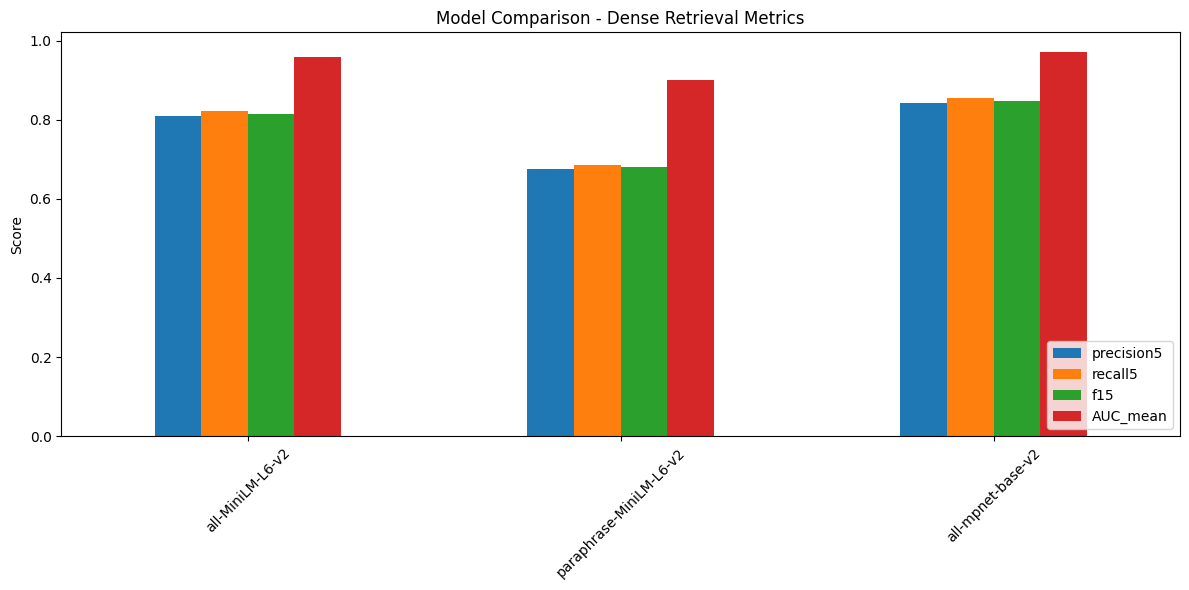

In [34]:
df_comparison.plot(kind='bar', figsize=(12, 6))
plt.title('Model Comparison - Dense Retrieval Metrics')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

Qualitative check: show top-10 candidates for a few queries with labels

In [35]:
model_name = "all-mpnet-base-v2"  # choose best model
data = embeddings_data[model_name]

corpus_embeddings = data["corpus_embeddings"]
query_embeddings = data["query_embeddings"]
corpus_ids = data["corpus_ids"]
query_ids = data["query_ids"]

corpus_index = {doc_id: idx for idx, doc_id in enumerate(corpus_ids)}
query_index = {q_id: idx for idx, q_id in enumerate(query_ids)}

sample_qids = list(qrels.keys())[:3]  # take 3 queries as examples

for qid in sample_qids:
    qidx = query_index[qid]
    q_emb = query_embeddings[qidx].reshape(1, -1)

    cand_dict = qrels[qid]
    candidate_ids = [cid for cid in cand_dict.keys() if cid in corpus_index]
    cand_indices = [corpus_index[cid] for cid in candidate_ids]
    cand_embs = corpus_embeddings[cand_indices]

    sims = cosine_similarity(q_emb, cand_embs)[0]
    order = np.argsort(-sims)

    print("\n==============================")
    print("Query ID:", qid)
    print("Query text:", queries[qid].get("text", "")[:200], "...")
    print("Top-10 candidates (should see many 1s in top-5):")

    for rank, j in enumerate(order[:10], start=1):
        cid = candidate_ids[j]
        label = cand_dict[cid]
        title = corpus[cid].get("title", "")
        print(f"{rank}. label={label} | score={sims[j]:.4f} | {title}")



Query ID: 01273bd34dacfe9ef887b320f36934d2f9fa9b34
Query text: Image-Guided Nanopositioning Scheme for SEM ...
Top-10 candidates (should see many 1s in top-5):
1. label=1 | score=0.5191 | Real-time rigid-body visual tracking in a scanning electron microscope
2. label=1 | score=0.3079 | Improving resolution by image registration
3. label=1 | score=0.3053 | Extension of phase correlation to subpixel registration
4. label=1 | score=0.2100 | A Comparison of Affine Region Detectors
5. label=0 | score=0.2018 | Kd-Jump: a Path-Preserving Stackless Traversal for Faster Isosurface Raytracing on GPUs
6. label=0 | score=0.1778 | Fully Convolutional Attention Networks for Fine-Grained Recognition
7. label=0 | score=0.1719 | Broadband antenna design using different 3D printing technologies and metallization processes
8. label=1 | score=0.1364 | Determining Optical Flow
9. label=0 | score=0.1321 | Focused Trajectory Planning for autonomous on-road driving
10. label=0 | score=0.1318 | An improved bo

### Intermède : exploration avec des modèles thématiques

In [36]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

lda_vectorizer = CountVectorizer(max_df=0.95, min_df=10, stop_words="english")
X_lda = lda_vectorizer.fit_transform(corpus_texts)
print("LDA document-term matrix shape:", X_lda.shape)

LDA document-term matrix shape: (25657, 2936)


In [37]:
n_topics = 10
lda_model = LatentDirichletAllocation(
    n_components=n_topics,
    random_state=42,
    learning_method="batch"
)
lda_model.fit(X_lda)
print("LDA model fitted with", n_topics, "topics")

LDA model fitted with 10 topics


In [38]:
def display_topics(model, feature_names, n_top_words=10):
    for topic_idx, topic in enumerate(model.components_):
        top_indices = topic.argsort()[:-n_top_words - 1:-1]
        top_words = [feature_names[i] for i in top_indices]
        print("Topic", topic_idx, ":", ", ".join(top_words))

lda_feature_names = lda_vectorizer.get_feature_names_out()
display_topics(lda_model, lda_feature_names, n_top_words=15)


Topic 0 : power, low, high, antenna, design, integrated, applications, using, cmos, based, array, digital, band, performance, technology
Topic 1 : review, study, internet, social, use, case, things, self, health, systematic, clinical, effects, literature, evidence, algorithm
Topic 2 : analysis, detection, using, classification, based, text, recognition, visual, study, data, techniques, automatic, features, information, extraction
Topic 3 : development, language, natural, processing, game, generation, problem, assessment, control, question, based, supervised, design, entity, quality
Topic 4 : using, image, learning, based, 3d, estimation, recognition, images, object, segmentation, deep, dc, single, detection, multi
Topic 5 : learning, based, machine, systems, approach, framework, reinforcement, survey, security, deep, end, using, model, multi, modeling
Topic 6 : based, time, using, real, sensor, detection, software, large, wireless, tracking, scale, efficient, energy, networks, vehicle


In [39]:
doc_topic_dist = lda_model.transform(X_lda)
for i in range(5):
    top_topic = doc_topic_dist[i].argmax()
    print("Document", corpus_ids[i], "main topic:", top_topic, "first topic probs:", doc_topic_dist[i][:5])


Document 632589828c8b9fca2c3a59e97451fde8fa7d188d main topic: 1 first topic probs: [0.22331177 0.39422881 0.01000091 0.01000144 0.01000061]
Document 86e87db2dab958f1bd5877dc7d5b8105d6e31e46 main topic: 0 first topic probs: [0.55233174 0.01428621 0.01428791 0.01429219 0.01428688]
Document 2a047d8c4c2a4825e0f0305294e7da14f8de6fd3 main topic: 9 first topic probs: [0.01000123 0.01000343 0.01000543 0.01000079 0.01000096]
Document 506172b0e0dd4269bdcfe96dda9ea9d8602bbfb6 main topic: 1 first topic probs: [0.02500565 0.77499203 0.02500076 0.025      0.02500132]
Document 51317b6082322a96b4570818b7a5ec8b2e330f2f main topic: 9 first topic probs: [0.01000135 0.01000029 0.01000134 0.01000101 0.01000134]


Display document titles with their dominant topic

In [40]:
for i in range(2):
    doc_id = corpus_ids[i]
    title = corpus[doc_id].get("title", "")
    top_topic = doc_topic_dist[i].argmax()
    topic_prob = doc_topic_dist[i][top_topic]

    print(f"Document ID: {doc_id}")
    print(f"Title: {title}")
    print(f"Dominant topic: {top_topic} (probability={topic_prob:.3f})\n")



Document ID: 632589828c8b9fca2c3a59e97451fde8fa7d188d
Title: A hybrid of genetic algorithm and particle swarm optimization for recurrent network design
Dominant topic: 1 (probability=0.394)

Document ID: 86e87db2dab958f1bd5877dc7d5b8105d6e31e46
Title: A Hybrid EP and SQP for Dynamic Economic Dispatch with Nonsmooth Fuel Cost Function
Dominant topic: 0 (probability=0.552)



Visualization of distribution of dominant topics

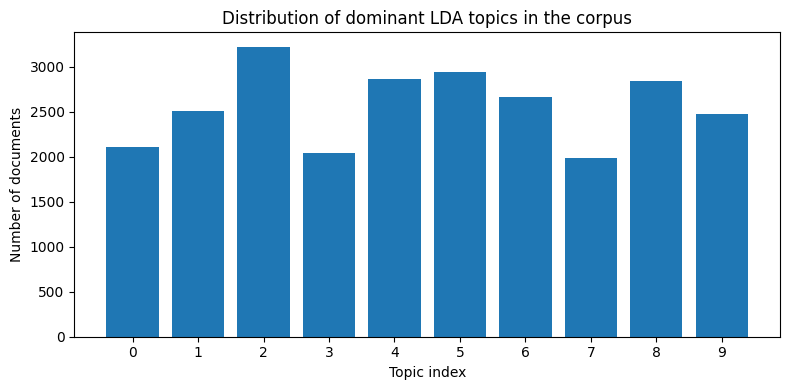

In [41]:
dominant_topics = doc_topic_dist.argmax(axis=1)
topic_counts = Counter(dominant_topics)

topics = list(topic_counts.keys())
counts = [topic_counts[t] for t in topics]

plt.figure(figsize=(8, 4))
plt.bar(topics, counts)
plt.xlabel("Topic index")
plt.ylabel("Number of documents")
plt.title("Distribution of dominant LDA topics in the corpus")
plt.xticks(topics)
plt.tight_layout()
plt.show()

### Construction du graphe de citations

In [42]:
citation_graph = nx.DiGraph()

for doc_id, doc in corpus.items():
    citation_graph.add_node(doc_id)
    meta = doc.get("metadata", {})

    refs = meta.get("references", [])
    if isinstance(refs, list):
        for ref_id in refs:
            if ref_id in corpus:
                citation_graph.add_edge(doc_id, ref_id)

    cited_by = meta.get("cited_by", [])
    if isinstance(cited_by, list):
        for src_id in cited_by:
            if src_id in corpus:
                citation_graph.add_edge(src_id, doc_id)

print("Citation graph built.")
print("Number of nodes:", citation_graph.number_of_nodes())
print("Number of edges:", citation_graph.number_of_edges())

Citation graph built.
Number of nodes: 25657
Number of edges: 54270


In [43]:
n_nodes = citation_graph.number_of_nodes()
n_edges = citation_graph.number_of_edges()
density = nx.density(citation_graph)

in_degrees = np.array([d for _, d in citation_graph.in_degree()])
out_degrees = np.array([d for _, d in citation_graph.out_degree()])

print("Graph density:", density)
print("In-degree mean:", in_degrees.mean(), "variance:", in_degrees.var())
print("Out-degree mean:", out_degrees.mean(), "variance:", out_degrees.var())

Graph density: 8.244512873344266e-05
In-degree mean: 2.1152122227852046 variance: 140.02741679344612
Out-degree mean: 2.1152122227852046 variance: 10.376327422124445


In [44]:
def top_k_nodes(score_dict, k=5):
    return sorted(score_dict.items(), key=lambda x: x[1], reverse=True)[:k]

degree_centrality = nx.degree_centrality(citation_graph)
pagerank_centrality = nx.pagerank(citation_graph, alpha=0.85)
betweenness_centrality = nx.betweenness_centrality(citation_graph, k=500, seed=42)

top_degree = top_k_nodes(degree_centrality, k=5)
top_pagerank = top_k_nodes(pagerank_centrality, k=5)
top_betweenness = top_k_nodes(betweenness_centrality, k=5)

print("Top nodes by degree centrality:")
for doc_id, score in top_degree:
    title = corpus.get(doc_id, {}).get("title", "")
    print(doc_id, "| score:", round(score, 6), "| title:", title)

print("\nTop nodes by PageRank:")
for doc_id, score in top_pagerank:
    title = corpus.get(doc_id, {}).get("title", "")
    print(doc_id, "| score:", round(score, 6), "| title:", title)

print("\nTop nodes by betweenness centrality:")
for doc_id, score in top_betweenness:
    title = corpus.get(doc_id, {}).get("title", "")
    print(doc_id, "| score:", round(score, 6), "| title:", title)


Top nodes by degree centrality:
2315fc6c2c0c4abd2443e26a26e7bb86df8e24cc | score: 0.029896 | title: ImageNet Classification with Deep Convolutional Neural Networks
272216c1f097706721096669d85b2843c23fa77d | score: 0.021009 | title: Adam: A Method for Stochastic Optimization
061356704ec86334dbbc073985375fe13cd39088 | score: 0.020775 | title: Very Deep Convolutional Networks for Large-Scale Image Recognition
0b3cfbf79d50dae4a16584533227bb728e3522aa | score: 0.017813 | title: Long Short-Term Memory
2c03df8b48bf3fa39054345bafabfeff15bfd11d | score: 0.017657 | title: Deep Residual Learning for Image Recognition

Top nodes by PageRank:
2315fc6c2c0c4abd2443e26a26e7bb86df8e24cc | score: 0.003631 | title: ImageNet Classification with Deep Convolutional Neural Networks
cbcd9f32b526397f88d18163875d04255e72137f | score: 0.003102 | title: Gradient-based learning applied to document recognition
4eb943bf999ce49e5ebb629d7d0ffee44becff94 | score: 0.002663 | title: Finding Structure in Time
0541d5338adc

Degree distribution of the citation graph

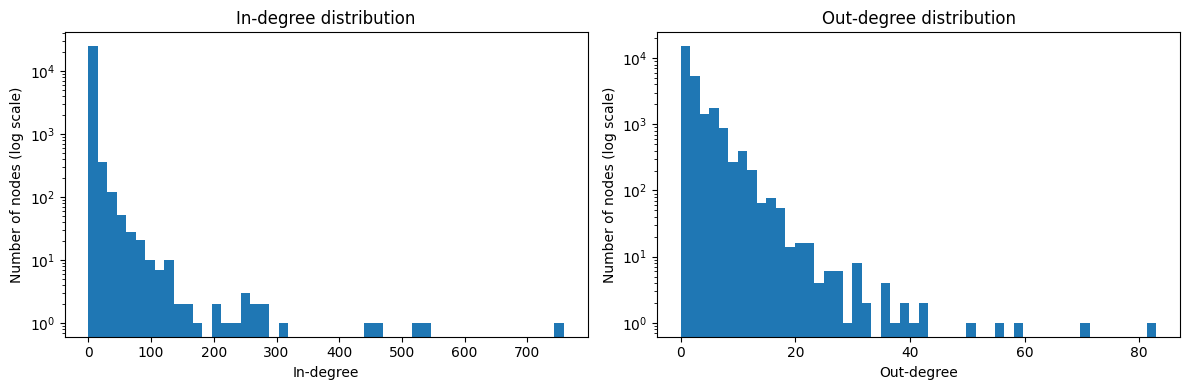

In [45]:
plt.figure(figsize=(12, 4))

# In-degree distribution
plt.subplot(1, 2, 1)
plt.hist(in_degrees, bins=50, log=True)
plt.xlabel("In-degree")
plt.ylabel("Number of nodes (log scale)")
plt.title("In-degree distribution")

# Out-degree distribution
plt.subplot(1, 2, 2)
plt.hist(out_degrees, bins=50, log=True)
plt.xlabel("Out-degree")
plt.ylabel("Number of nodes (log scale)")
plt.title("Out-degree distribution")

plt.tight_layout()
plt.show()


### Construire des meilleures représentations pour les noeuds

Graph-enhanced embeddings, evaluate multiple alpha values

In [46]:
alphas = [0.5, 0.7, 0.9]
results = {}

corpus_index = {doc_id: idx for idx, doc_id in enumerate(corpus_ids)}

# Baseline
results["baseline"] = evaluate_dense_search(
    qrels,
    corpus_embeddings,
    query_embeddings,
    corpus_ids,
    query_ids,
    top_k=5
)

for alpha in alphas:
    emb_graph = np.zeros_like(corpus_embeddings)

    for i, doc_id in enumerate(corpus_ids):
        neighbors = set(citation_graph.predecessors(doc_id)) | set(citation_graph.successors(doc_id))
        idxs = [corpus_index[n] for n in neighbors if n in corpus_index]

        if idxs:
            emb_graph[i] = alpha * corpus_embeddings[i] + (1 - alpha) * corpus_embeddings[idxs].mean(axis=0)
        else:
            emb_graph[i] = corpus_embeddings[i]

    # normalize
    norms = np.linalg.norm(emb_graph, axis=1, keepdims=True)
    emb_graph[norms.squeeze() > 0] /= norms[norms.squeeze() > 0]

    results[f"alpha={alpha}"] = evaluate_dense_search(
        qrels,
        emb_graph,
        query_embeddings,
        corpus_ids,
        query_ids,
        top_k=5
    )

df_alpha = pd.DataFrame(results).T
display(df_alpha)


,precision5,recall5,f15,AUC_mean
baseline,0.841714,0.854262,0.846864,0.972288
alpha=0.5,0.869714,0.882929,0.875134,0.979129
alpha=0.7,0.858857,0.871881,0.864205,0.976846
alpha=0.9,0.848571,0.861262,0.853785,0.973996


Compare baseline vs graph-enhanced for different alphas

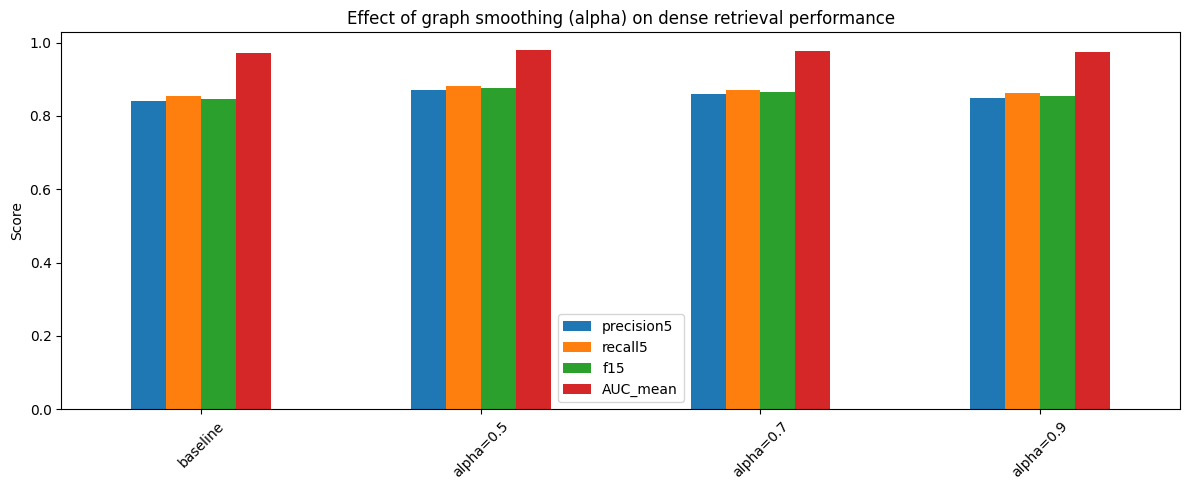

In [47]:
df_alpha.plot(kind="bar", figsize=(12, 5))
plt.title("Effect of graph smoothing (alpha) on dense retrieval performance")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Creating a submission file for kaddle

In [48]:
TEST_PATH = "dataset_BE2/test_final.tsv"
SAMPLE_SUB_PATH = "dataset_BE2/sample_submission.csv" 

test_df = pd.read_csv(TEST_PATH, sep="\t")
sample_df = pd.read_csv(SAMPLE_SUB_PATH)

print("test_final.tsv columns:", list(test_df.columns))
print("sample_submission.csv columns:", list(sample_df.columns))
print("test rows:", len(test_df), "| sample rows:", len(sample_df))

required_test_cols = {"query-id", "corpus-id"}
required_sample_cols = {"RowId", "query-id", "corpus-id", "score"}

assert required_test_cols.issubset(set(test_df.columns)), "test_final.tsv must contain query-id and corpus-id"
assert required_sample_cols.issubset(set(sample_df.columns)), "sample_submission.csv columns mismatch"
assert len(test_df) == len(sample_df), "test_final.tsv and sample_submission.csv should have same number of rows"


test_final.tsv columns: ['query-id', 'corpus-id', 'score']
sample_submission.csv columns: ['RowId', 'query-id', 'corpus-id', 'score']
test rows: 8978 | sample rows: 8978


In [49]:
# Choose the best dense model (based on your validation results)
MODEL_NAME = "all-mpnet-base-v2"

data = embeddings_data[MODEL_NAME]
corpus_embeddings = data["corpus_embeddings"]
query_embeddings = data["query_embeddings"]
corpus_ids = data["corpus_ids"]
query_ids = data["query_ids"]

# Build indices for fast lookup
corpus_index = {doc_id: idx for idx, doc_id in enumerate(corpus_ids)}
query_index = {q_id: idx for idx, q_id in enumerate(query_ids)}

print("Embeddings loaded:")
print(" corpus_embeddings:", corpus_embeddings.shape)
print(" query_embeddings:", query_embeddings.shape)

Embeddings loaded:
 corpus_embeddings: (25657, 768)
 query_embeddings: (1000, 768)


In [50]:
USE_GRAPH = False
ALPHA = 0.7      

if USE_GRAPH:
    emb_graph = np.zeros_like(corpus_embeddings)
    for i, doc_id in enumerate(corpus_ids):
        neighbors = set(citation_graph.predecessors(doc_id)) | set(citation_graph.successors(doc_id))
        idxs = [corpus_index[n] for n in neighbors if n in corpus_index]
        if idxs:
            emb_graph[i] = ALPHA * corpus_embeddings[i] + (1 - ALPHA) * corpus_embeddings[idxs].mean(axis=0)
        else:
            emb_graph[i] = corpus_embeddings[i]

    norms = np.linalg.norm(emb_graph, axis=1, keepdims=True)
    mask = norms.squeeze() > 0
    emb_graph[mask] /= norms[mask]

    corpus_embeddings_to_use = emb_graph
    print(f"Using graph-enhanced corpus embeddings (alpha={ALPHA}).")
else:
    corpus_embeddings_to_use = corpus_embeddings
    print("Using baseline dense corpus embeddings.")


Using baseline dense corpus embeddings.


In [51]:
# Compute predicted scores row-by-row (fast dot product because embeddings are normalized)
qids = test_df["query-id"].values
cids = test_df["corpus-id"].values

pred_scores = np.empty(len(test_df), dtype=np.float32)

missing_q = 0
missing_c = 0

for i, (qid, cid) in enumerate(zip(qids, cids)):
    qi = query_index.get(qid, None)
    ci = corpus_index.get(cid, None)

    if qi is None:
        pred_scores[i] = 0.0
        missing_q += 1
        continue
    if ci is None:
        pred_scores[i] = 0.0
        missing_c += 1
        continue

    q_emb = query_embeddings[qi]
    c_emb = corpus_embeddings_to_use[ci]
    pred_scores[i] = float(np.dot(q_emb, c_emb))  # cosine similarity

print("Done scoring.")
print("Missing query ids:", missing_q)
print("Missing corpus ids:", missing_c)

# Build submission exactly like sample_submission.csv
submission_df = pd.DataFrame({
    "RowId": sample_df["RowId"].values,
    "query-id": test_df["query-id"].values,
    "corpus-id": test_df["corpus-id"].values,
    "score": pred_scores
})

submission_df.head()


Done scoring.
Missing query ids: 0
Missing corpus ids: 0


,RowId,query-id,corpus-id,score
0,1,7b901e88e8a4afcc4c60c52833820156525f4aed,60e0cc24c7801193bab359211b74f20737486620,-0.092269
1,2,7b901e88e8a4afcc4c60c52833820156525f4aed,4547045fecfb303140adafde3384ab5b1d70dd7c,0.264954
2,3,7b901e88e8a4afcc4c60c52833820156525f4aed,c5398cca4c6d5342b3e1568b08deddea57a9ab4f,0.056497
3,4,7b901e88e8a4afcc4c60c52833820156525f4aed,e406f1648c3ce88c2d6e6152e67105e92af76f31,0.049869
4,5,7b901e88e8a4afcc4c60c52833820156525f4aed,26afb306b0f3b6347382dc33efdd0f8dd4d6ea73,-0.013154


In [52]:
OUT_PATH = "submission1.csv"
submission_df.to_csv(OUT_PATH, index=False)
print("Saved:", OUT_PATH)

Saved: submission1.csv
